<table class="table table-bordered">
    <tr>
        <th style="width:250px"><img src='https://www.np.edu.sg/images/default-source/default-album/img-logo.png?sfvrsn=764583a6_0' style="width: 100%; height: 125px; "></th>
        <th style="text-align:center;"><h1>Distributed Data Pipelines</h1><h2>Assignment 1 </h2><h3>Diploma in Data Science</h3></th>
    </tr>
</table>

Learning Objectives:
- Design PySpark Based Machine Learning
- Execute PySpark Syntax Correctly
- Evaluate and Select Final Model based on Metrics

You will be **graded on the use of PySpark**, so usage of **Pandas itself should be avoided as much as possible**, especially if a particular native method or function is already available in PySpark. **Penalties will be imposed in such cases.**

# Table of Contents <a id="part0"></a>
[Step 1](#part1): Problem Statement Formulation

[Step 2](#part2): Exploratory Data Analysis and Data Cleansing

[Step 3](#part3): Data Wrangling and Transformation

[Step 4](#part4): Machine Learning Model

[Step 5](#part5): Model Evaluation and Selection 

[Step 6](#part6): Report


In [1]:
# import the packages
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('6.1').getOrCreate()

from pyspark.sql.functions import col, isnan, when, count, round
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, countDistinct
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import Imputer
import pyspark.sql.functions as f
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import when

### Step 1: Problem Statement Formulation  <a id="part1"></a>
[Back to the top](#part0)
- Load and Explore the Data
- Understand the Data
- Formulate a Value Based Problem Statement

<b> Load an Explore the Data

In [2]:
# load and explore data
df=spark.read.csv('./data/sg_flat_prices_mod.csv', header=True, inferSchema=True)
print(df.printSchema())
print(type(df))
print('Shape:(',df.count(),',',len(df.columns),')')
print()
df.show(5)

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- town: string (nullable = true)
 |-- flat_type: string (nullable = true)
 |-- block: string (nullable = true)
 |-- street_name: string (nullable = true)
 |-- storey_range: string (nullable = true)
 |-- floor_area_sqm: double (nullable = true)
 |-- flat_model: string (nullable = true)
 |-- lease_commence_date: integer (nullable = true)
 |-- remaining_lease: integer (nullable = true)
 |-- resale_price: double (nullable = true)

None
<class 'pyspark.sql.dataframe.DataFrame'>
Shape:( 64247 , 12 )

+----+-----+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+---------------+------------+
|year|month|      town|flat_type|block|      street_name|storey_range|floor_area_sqm|    flat_model|lease_commence_date|remaining_lease|resale_price|
+----+-----+----------+---------+-----+-----------------+------------+--------------+--------------+-----------------

<b>Understand the Data

1. Given the year and month of the transaction 
2. Given the town and address(block+street name) of the flat 
3. Given the flat type, flat model and storey range of the flat
4. Given the information about the lease of the flat
5. Target variable - resale_price

<b> Formulate a Value Based Problem Statement
    
This project aims to create a machine-learning model for predicting the resale prices of HDB flats using their properties from the data given.  
    
Using the model, we can find how the selling price of an HDB resale flat changes based on the information given. 

### Step 2: Exploratory Data Analysis and Data Cleansing <a id="part2"></a>
[Back to the top](#part0)
- Interesting Trends
- Anomalies
- Potential Errors
- Missing Value Treatment

In [3]:
#### Check max values
df.groupBy().max().show()

+---------+----------+-------------------+------------------------+--------------------+-----------------+
|max(year)|max(month)|max(floor_area_sqm)|max(lease_commence_date)|max(remaining_lease)|max(resale_price)|
+---------+----------+-------------------+------------------------+--------------------+-----------------+
|     2019|        12|              249.0|                    2016|                1160|        1205000.0|
+---------+----------+-------------------+------------------------+--------------------+-----------------+



In [4]:
#Check min values
df.groupBy().min().show()

+---------+----------+-------------------+------------------------+--------------------+-----------------+
|min(year)|min(month)|min(floor_area_sqm)|min(lease_commence_date)|min(remaining_lease)|min(resale_price)|
+---------+----------+-------------------+------------------------+--------------------+-----------------+
|     2017|         1|               31.0|                    1966|                 553|         150000.0|
+---------+----------+-------------------+------------------------+--------------------+-----------------+



1. Given data from Jan 2017- Dec 2019
2. <b>Anomalies</b>: remaining_lease seems to be in months when its expected to be in years


In [5]:
#Transformng remaining_lease to remaining_lease in years
df=df.withColumn("remaining_lease(years)", round(col("remaining_lease") / 12,0))
df=df.drop('remaining_lease')

<b> Checking correlation

<a id="part2a"></a>
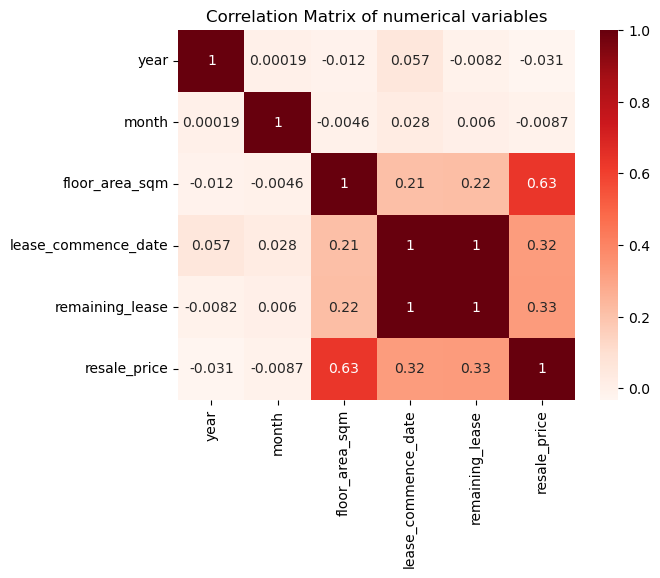

1. Year and the month of the transaction date have a weak negative correlation to resale_price
2. The floor area in sqm have the strongest positive correlation to the resale_price
3. Lease commence date and remaining lease have a strong positive correlation to the resale price
4. <b>Potential Error</b>: Remaining lease has a direct relationship with lease commence date 


<b>Using groupby to explore 'flat_type','storey_range','town' against average resale price

<b>Flat Type</b>

From the box plot we see that each flat type have their own range of sizes.
<a id="part2b"></a>
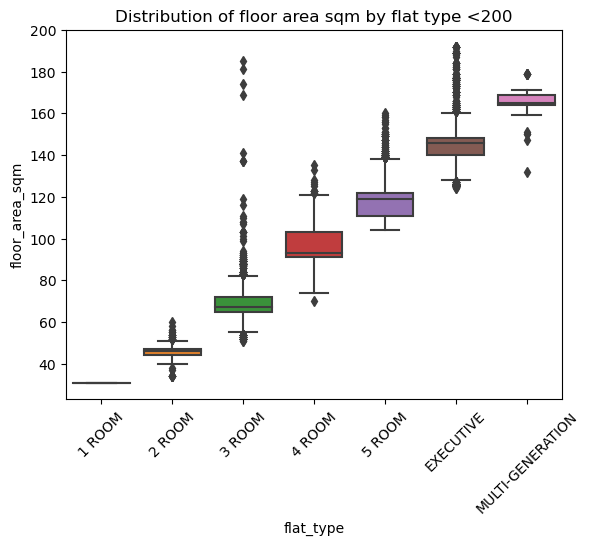



In [6]:
#Groupby flat type - Average resale price
temp_df=df.groupBy('flat_type').avg("resale_price").orderBy('avg(resale_price)',ascending=False)
temp_df.select('flat_type',round('avg(resale_price)',2).alias('avg_resale_price')).show()

+----------------+----------------+
|       flat_type|avg_resale_price|
+----------------+----------------+
|MULTI-GENERATION|       806804.61|
|       EXECUTIVE|       625390.66|
|          5 ROOM|       528812.86|
|          4 ROOM|       432760.11|
|          3 ROOM|       307712.28|
|          2 ROOM|       233600.69|
|          1 ROOM|       186181.66|
+----------------+----------------+



Larger flat types tend to sell for more money (With aid of box plot)

<b>Storey Range</b>

In [7]:
#Groupby storey range - Average resale price
temp_df=df.groupBy('storey_range').avg("resale_price").orderBy('avg(resale_price)',ascending=False)
temp_df.select('storey_range',round('avg(resale_price)',2).alias('avg_resale_price')).show()

+------------+----------------+
|storey_range|avg_resale_price|
+------------+----------------+
|    43 TO 45|      1037833.33|
|    49 TO 51|      1022814.67|
|    46 TO 48|      1018845.45|
|    40 TO 42|       894045.94|
|    37 TO 39|       845602.77|
|    34 TO 36|        802757.9|
|    31 TO 33|       800630.93|
|    28 TO 30|       751391.76|
|    25 TO 27|       666919.14|
|    22 TO 24|       610122.55|
|    19 TO 21|       591394.68|
|    16 TO 18|       514570.94|
|    13 TO 15|       472987.88|
|    10 TO 12|       438086.75|
|    07 TO 09|       423477.67|
|    04 TO 06|       412115.97|
|    01 TO 03|       394274.28|
+------------+----------------+



Higher leveled apartments typically sell for a higher price

<b>Town</b>

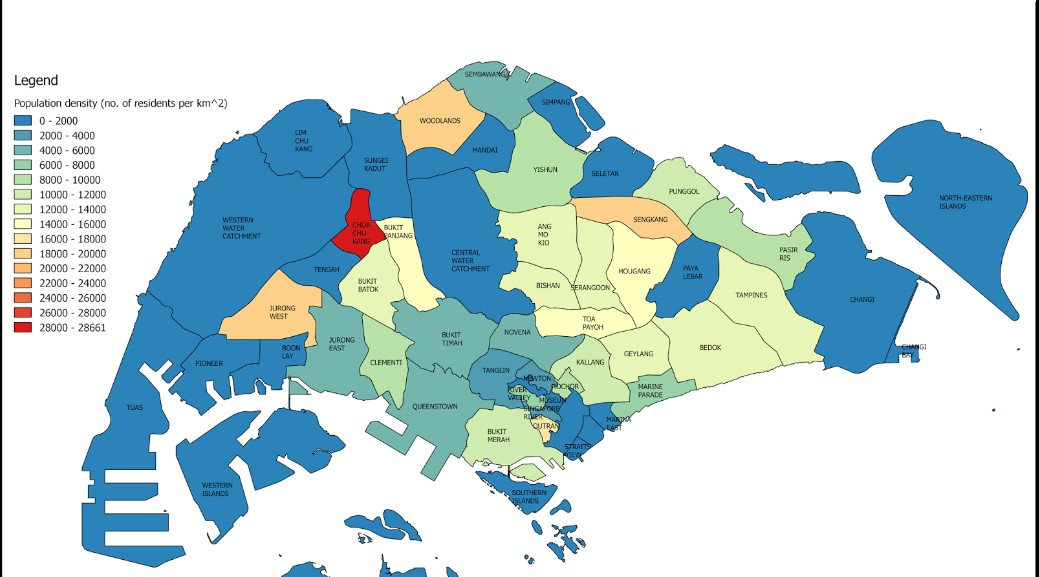
HDB Estate Map - Ignore the colors

In [8]:
#Groupby town - Average resale price
temp_df=df.groupBy('town').avg("resale_price").orderBy('avg(resale_price)',ascending=False)
temp_df.select('town',round('avg(resale_price)',2).alias('avg_resale_price')).show()

+---------------+----------------+
|           town|avg_resale_price|
+---------------+----------------+
|    BUKIT TIMAH|       714816.97|
|         BISHAN|       644789.63|
|   CENTRAL AREA|       623428.02|
|    BUKIT MERAH|       564024.88|
|     QUEENSTOWN|       554835.85|
|  MARINE PARADE|       518115.92|
|KALLANG/WHAMPOA|       496043.73|
|      TOA PAYOH|       494166.75|
|      PASIR RIS|       492123.09|
|      SERANGOON|       490769.09|
|       TAMPINES|       474205.32|
|       CLEMENTI|       469028.61|
|        PUNGGOL|       453269.61|
|       SENGKANG|       433994.12|
|        GEYLANG|       430605.67|
|        HOUGANG|       429212.75|
|  BUKIT PANJANG|       428196.39|
|    JURONG EAST|       416185.77|
|     ANG MO KIO|        411547.2|
|          BEDOK|       410944.05|
+---------------+----------------+
only showing top 20 rows



Towns near the central area are more expensive. (With aid of map)

#### Drop Unnecessary Columns

In [9]:
#Number of unique values from each column 
df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns)).show()

+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+------------+----------------------+
|year|month|town|flat_type|block|street_name|storey_range|floor_area_sqm|flat_model|lease_commence_date|resale_price|remaining_lease(years)|
+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+------------+----------------------+
|   3|   12|  26|        7| 2387|        541|          17|           159|        19|                 51|        2248|                    52|
+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+------------+----------------------+



In [10]:
#Drop Unnecessary Columns
df = df.drop("lease_commence_date",'block','street_name')
df.show(5)

+----+-----+----------+---------+------------+--------------+--------------+------------+----------------------+
|year|month|      town|flat_type|storey_range|floor_area_sqm|    flat_model|resale_price|remaining_lease(years)|
+----+-----+----------+---------+------------+--------------+--------------+------------+----------------------+
|2017|    1|ANG MO KIO|   2 ROOM|    10 TO 12|          44.0|      Improved|    232000.0|                  61.0|
|2017|    1|ANG MO KIO|   3 ROOM|    01 TO 03|          67.0|New Generation|    250000.0|                  61.0|
|2017|    1|ANG MO KIO|   3 ROOM|    01 TO 03|          67.0|New Generation|    262000.0|                  62.0|
|2017|    1|ANG MO KIO|   3 ROOM|    04 TO 06|          68.0|New Generation|    265000.0|                  62.0|
|2017|    1|ANG MO KIO|   3 ROOM|    01 TO 03|          67.0|New Generation|    265000.0|                  62.0|
+----+-----+----------+---------+------------+--------------+--------------+------------+-------

1. In the previous heatmap, it is shown that lease commence date and remaining lease have a direct relationship. Since they both represent the same thing and will not provide any new information, I dropped lease commence date.
2. Block and street name are only useful if we are able to determine if it is near an MRT or central areas. Since, we are not doing any web scraping, it is not that impactful. Therefore, I dropped it.

#### Missing value treatment

In [11]:
#Only floor_area_sqm has null values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+-----+----+---------+------------+--------------+----------+------------+----------------------+
|year|month|town|flat_type|storey_range|floor_area_sqm|flat_model|resale_price|remaining_lease(years)|
+----+-----+----+---------+------------+--------------+----------+------------+----------------------+
|   0|    0|   0|        0|           0|            50|         0|           0|                     0|
+----+-----+----+---------+------------+--------------+----------+------------+----------------------+



In [12]:
# filter and show rows with NaNs
df.filter(df.floor_area_sqm.isNull()).show(5)

+----+-----+----------+---------+------------+--------------+----------+------------+----------------------+
|year|month|      town|flat_type|storey_range|floor_area_sqm|flat_model|resale_price|remaining_lease(years)|
+----+-----+----------+---------+------------+--------------+----------+------------+----------------------+
|2017|    3|QUEENSTOWN|   4 ROOM|    19 TO 21|          null|  Improved|    556000.0|                  52.0|
|2017|    3| TOA PAYOH|   4 ROOM|    16 TO 18|          null|  Improved|    383000.0|                  58.0|
|2017|    3| TOA PAYOH|   4 ROOM|    16 TO 18|          null|  Improved|    390000.0|                  57.0|
|2017|    3| TOA PAYOH|   4 ROOM|    13 TO 15|          null|  Improved|    420000.0|                  55.0|
|2017|    3| TOA PAYOH|   4 ROOM|    07 TO 09|          null|  Improved|    420000.0|                  55.0|
+----+-----+----------+---------+------------+--------------+----------+------------+----------------------+
only showing top 5 

In [13]:
#All the null values are in the 4 Room flat type
df.filter(df.floor_area_sqm.isNull()).select('flat_type').distinct().collect()

[Row(flat_type='4 ROOM')]

<b>Could impute based on 4 Room flat type floor area sqm if there were a lot more missing values (Code provided below)

#mean of floor area sqm for 4 Room flat type

mean_to_replace=df.groupby('flat_type').mean('floor_area_sqm').filter(
    df['flat_type']=='4 ROOM').collect()[0]['avg(floor_area_sqm)']
    
#Replace missing values with mean
df=df.fillna(value=mean_to_replace)

In [14]:
#Percentage of null values
50/64247*100

0.0778246455087397

In [15]:
#Complete Case Analysis
df=df.na.drop(subset=["floor_area_sqm"])

### Step 3: Data Wrangling and Transformation  <a id="part3"></a>
[Back to the top](#part0)
- Categorical Data
- Numerical Data
- Feature Scaling

<b> Pipeline created for categorical encoding and another for Feature Scaling

### Dealing with outlier

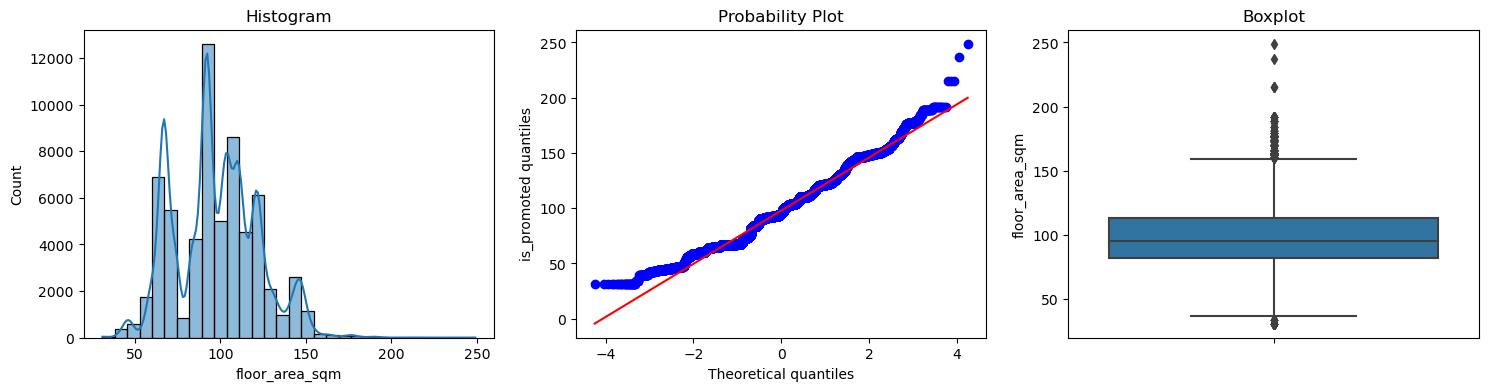

In [16]:
#Interquartile range rule
#Flagging outliers
features=['floor_area_sqm']
quantiles=[0.25,0.75]
cut_off_points=[]
#Get cut off point
for feature in features:
    quants=df.approxQuantile(feature,quantiles,0.05)
    IQR=quants[1]-quants[0]
    cut_off_points.append((feature,[
        quants[0]-1.5*IQR,
        quants[1]+1.5*IQR
    ]))
cut_off_points=dict(cut_off_points)
#Flag outlier
outliers=df.select(*['town']+[
    (
        (df[f]<cut_off_points[f][0]) |
         (df[f]>cut_off_points[f][1]) 
    ).alias(f+'_O') for f in features
])
print("Number of outliers:"+ str(outliers.filter(outliers.floor_area_sqm_O=='true').count()))
print("Cut off points: "+str(cut_off_points))

Number of outliers:620
Cut off points: {'floor_area_sqm': [40.0, 152.0]}


<b> Cap outliers to the limit (upper or lower) that they are closest to </b>

#Cap to lower
df=df.withColumn("floor_area_sqm", \
              when(df["floor_area_sqm"]<cut_off_points["floor_area_sqm"][0],
                   cut_off_points["floor_area_sqm"][0]).otherwise(df["floor_area_sqm"]))
#Cap to upper
df=df.withColumn("floor_area_sqm", \
              when(df["floor_area_sqm"]>cut_off_points["floor_area_sqm"][1],
                   cut_off_points["floor_area_sqm"][1]).otherwise(df["floor_area_sqm"]))

<b>Remove outliers 
    
df=df.filter((df.floor_area_sqm>cut_off_points['floor_area_sqm'][0]) &
                        (df.floor_area_sqm<cut_off_points['floor_area_sqm'][1]))

<b> Without Touching Outlier - Best


### Categorical Data Encoding

In [17]:
#Number of unique values for categorical columns - Train
cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')] 
print("cat_cols:", cat_cols)
df.agg(*(countDistinct(col(c)).alias(c) for c in cat_cols)).show()

cat_cols: ['town', 'flat_type', 'storey_range', 'flat_model']
+----+---------+------------+----------+
|town|flat_type|storey_range|flat_model|
+----+---------+------------+----------+
|  26|        7|          17|        19|
+----+---------+------------+----------+





<b> Selected Method: One hot encoding for everything -Best

In [18]:
##### One hot encoding for everything
strings_used = ["town", "flat_type","flat_model",'storey_range']

stage_string = [StringIndexer(inputCol= c, outputCol= c+"_string_encoded") for c in strings_used]
stage_one_hot = [OneHotEncoder(inputCol= c+"_string_encoded", outputCol= c+ "_one_hot") for c in strings_used]

#Pipeline
ppl = Pipeline(stages= stage_string + stage_one_hot)
pyspark_index_ohe = ppl.fit(df).transform(df)

#Drop
pyspark_index_ohe=pyspark_index_ohe.drop("town", "flat_type","flat_model","town_string_encoded",
                                         "flat_type_string_encoded",
                                         "flat_model_string_encoded",'storey_range','storey_range_string_encoded')


##### OHE+Ordinal encoding of storey range
#One hot encoding without storey range
strings_used = ["town", "flat_type","flat_model"]

stage_string = [StringIndexer(inputCol= c, outputCol= c+"_string_encoded") for c in strings_used]
stage_one_hot = [OneHotEncoder(inputCol= c+"_string_encoded", outputCol= c+ "_one_hot") for c in strings_used]

ppl = Pipeline(stages= stage_string + stage_one_hot)
pyspark_index_ohe = ppl.fit(df).transform(df)

#Manually ordinally encode storey range
to_replace_dict={'01 TO 03':'0','04 TO 06':'1','07 TO 09':'2','10 TO 12':'3','13 TO 15':'4',
                '16 TO 18':'5','19 TO 21':'6','22 TO 24':'7','25 TO 27':'8','28 TO 30':'9',
                 '31 TO 33':'10','34 TO 36':'11','37 TO 39':'12','40 TO 42':'13','43 TO 45':'14',
                 '46 TO 48':'15','49 TO 51':'16'
                }

pyspark_index_ohe = pyspark_index_ohe.replace(to_replace_dict,subset=['storey_range'])
pyspark_index_ohe=pyspark_index_ohe.withColumn('storey_range_ord',pyspark_index_ohe['storey_range'].cast('int'))

#Drop 
pyspark_index_ohe=pyspark_index_ohe.drop("town", "flat_type","flat_model","town_string_encoded",
                                         "flat_type_string_encoded",
                                         "flat_model_string_encoded",'storey_range')

##### OHE+Ordinal encoding of flat type
#One hot encoding without storey range
strings_used = ["town","flat_model",'storey_range']

stage_string = [StringIndexer(inputCol= c, outputCol= c+"_string_encoded") for c in strings_used]
stage_one_hot = [OneHotEncoder(inputCol= c+"_string_encoded", outputCol= c+ "_one_hot") for c in strings_used]

ppl = Pipeline(stages= stage_string + stage_one_hot)
pyspark_index_ohe = ppl.fit(df).transform(df)

#Manually ordinally encode flat_type
to_replace_dict={'1 ROOM':'0','2 ROOM':'1','3 ROOM':'2','4 ROOM':'3','5 ROOM':'4','EXECUTIVE':'5','MULTI-GENERATION':'6'
                }
pyspark_index_ohe = pyspark_index_ohe.replace(to_replace_dict,subset=['flat_type'])
pyspark_index_ohe=pyspark_index_ohe.withColumn('flat_type_ord',pyspark_index_ohe['flat_type'].cast('int'))

#Drop 
pyspark_index_ohe=pyspark_index_ohe.drop("town", "flat_type","flat_model","town_string_encoded",
                                         "flat_model_string_encoded",'storey_range', "storey_range_string_encoded")


##### OHE+Ordinal encoding of storey range+Ordinal encoding of flat_type
#One hot encoding without storey range
strings_used = ["town","flat_model"]

stage_string = [StringIndexer(inputCol= c, outputCol= c+"_string_encoded") for c in strings_used]
stage_one_hot = [OneHotEncoder(inputCol= c+"_string_encoded", outputCol= c+ "_one_hot") for c in strings_used]

ppl = Pipeline(stages= stage_string + stage_one_hot)
pyspark_index_ohe = ppl.fit(df).transform(df)

#Manually ordinally encode storey range
to_replace_dict={'01 TO 03':'0','04 TO 06':'1','07 TO 09':'2','10 TO 12':'3','13 TO 15':'4',
                '16 TO 18':'5','19 TO 21':'6','22 TO 24':'7','25 TO 27':'8','28 TO 30':'9',
                 '31 TO 33':'10','34 TO 36':'11','37 TO 39':'12','40 TO 42':'13','43 TO 45':'14',
                 '46 TO 48':'15','49 TO 51':'16'
                }

pyspark_index_ohe = pyspark_index_ohe.replace(to_replace_dict,subset=['storey_range'])
pyspark_index_ohe=pyspark_index_ohe.withColumn('storey_range_ord',pyspark_index_ohe['storey_range'].cast('int'))

#Manually ordinally encode flat_type
to_replace_dict={'1 ROOM':'0','2 ROOM':'1','3 ROOM':'2','4 ROOM':'3','5 ROOM':'4','EXECUTIVE':'5','MULTI-GENERATION':'6'
                }
pyspark_index_ohe = pyspark_index_ohe.replace(to_replace_dict,subset=['flat_type'])
pyspark_index_ohe=pyspark_index_ohe.withColumn('flat_type_ord',pyspark_index_ohe['flat_type'].cast('int'))

#Drop 
pyspark_index_ohe=pyspark_index_ohe.drop("town", "flat_type","flat_model","town_string_encoded",
                                         "flat_model_string_encoded",'storey_range')

#### Train Test Split

In [19]:
(train, test) = pyspark_index_ohe.randomSplit([0.8, 0.2], seed=0)

### Numerical Data Transformation

#### Feature Scaling

In [20]:
#Pipeline for numerical Scaling

#featureassembler for scaling
temp_list=pyspark_index_ohe.columns
temp_list.remove('resale_price')
temp_list.append('resale_price')
featureassembler=VectorAssembler(inputCols=temp_list[:-1],outputCol="Xcols")

#Scaling
sScaler = StandardScaler(withMean=True, withStd=True, inputCol="Xcols", outputCol="Xcols_scaled") #Standardization
mScaler = MinMaxScaler(inputCol="Xcols", outputCol="Xcols_scaled") # Min Max Scaler
#Pipeline
ppl=Pipeline(stages= [featureassembler, sScaler])
train_scaled= ppl.fit(train).transform(train)
test_scaled=ppl.fit(test).transform(test)

##### Standard Scaler - Best

##### MinMax Scaler

#### Final Tidy-up and Check before Modeling

In [21]:
#For scaling everything
train_data = train_scaled.select("Xcols_scaled","resale_price")
test_data = test_scaled.select("Xcols_scaled","resale_price")
train_data.show(5)
test_data.show(5)

+--------------------+------------+
|        Xcols_scaled|resale_price|
+--------------------+------------+
|[-1.2618900826554...|    218000.0|
|[-1.2618900826554...|    230000.0|
|[-1.2618900826554...|    205000.0|
|[-1.2618900826554...|    215000.0|
|[-1.2618900826554...|    228500.0|
+--------------------+------------+
only showing top 5 rows

+--------------------+------------+
|        Xcols_scaled|resale_price|
+--------------------+------------+
|[-1.2504184037821...|    238000.0|
|[-1.2504184037821...|    240000.0|
|[-1.2504184037821...|    260000.0|
|[-1.2504184037821...|    263000.0|
|[-1.2504184037821...|    275000.0|
+--------------------+------------+
only showing top 5 rows



### Step 4: Machine Learning Modelling<a id="part4"></a>
[Back to the top](#part0)
- Show Count of Rows and Columns
- Sample of 10 Rows before Modelling
- Build the Predictive Model

In [22]:
# how to we train or test our models?

In [23]:
# use code to show number of rows and columns,
# as well as a sample of 10 rows before heading into Machine Learning Modelling

In [24]:
#Total rows and features used
pyspark_index_ohe.count(), len(pyspark_index_ohe.columns)

(64197, 9)

In [25]:
train.count(), len(train.columns)

(51379, 9)

In [26]:
test.count(), len(test.columns)

(12818, 9)

In [27]:
#Sample of 10 Rows before Modelling
train_data.show(10)

+--------------------+------------+
|        Xcols_scaled|resale_price|
+--------------------+------------+
|[-1.2618900826554...|    218000.0|
|[-1.2618900826554...|    230000.0|
|[-1.2618900826554...|    205000.0|
|[-1.2618900826554...|    215000.0|
|[-1.2618900826554...|    228500.0|
|[-1.2618900826554...|    232000.0|
|[-1.2618900826554...|    238000.0|
|[-1.2618900826554...|    245000.0|
|[-1.2618900826554...|    250000.0|
|[-1.2618900826554...|    220000.0|
+--------------------+------------+
only showing top 10 rows



In [28]:
#Sample of 10 Rows before Modelling
test_data.show(10)

+--------------------+------------+
|        Xcols_scaled|resale_price|
+--------------------+------------+
|[-1.2504184037821...|    238000.0|
|[-1.2504184037821...|    240000.0|
|[-1.2504184037821...|    260000.0|
|[-1.2504184037821...|    263000.0|
|[-1.2504184037821...|    275000.0|
|[-1.2504184037821...|    320000.0|
|[-1.2504184037821...|    350000.0|
|[-1.2504184037821...|    388000.0|
|[-1.2504184037821...|    290000.0|
|[-1.2504184037821...|    300000.0|
+--------------------+------------+
only showing top 10 rows



In [29]:
#Create LR Model - is a basic and commonly used type of predictive analysis.
regressor=LinearRegression(featuresCol="Xcols_scaled", labelCol="resale_price")
regressor=regressor.fit(train_data)

In [30]:
#coefficients
regressor.coefficients

DenseVector([-541.3045, 220.6678, 87177.3973, 56866.8335, -99136.0236, -92490.3276, -89604.4417, -79240.3311, -59866.1806, -79258.1794, -48224.6467, -60282.2121, -43884.7705, -76198.9152, -19209.4376, -56104.1912, -62687.5841, -28490.8281, -25912.6017, -51754.3653, -64380.774, -14236.597, -25162.1646, -40189.2439, -24667.3516, -29235.7406, -14183.9831, -8912.1411, -3842.0558, 44110.3035, 45191.6673, 30820.9811, 30221.0835, 5529.6816, 2386.1619, -24255.1267, -22925.8481, -12282.1225, -13980.4224, -7709.6379, -2945.6441, 3272.0855, -6571.3215, 10164.7382, -6169.7386, 571.5011, 5634.5343, 2560.1641, 4992.1034, 6459.3053, 2386.1619, 2124.9294, 1600.5413, -69747.6814, -62823.3847, -56479.8513, -69561.5324, -38956.6414, -23596.9291, -11428.8029, -9195.6227, -5109.7724, -2569.6542, -1438.2268, -424.4616, -2148.0792, 376.8782, -103.8056, 58.7691])

In [31]:
# Intercept
regressor.intercept

438856.4713340098

In [32]:
# first row values of Xcols_sscaled
train_data.take(1)

[Row(Xcols_scaled=DenseVector([-1.2619, -1.7715, -2.6206, -1.6524, -0.2898, -0.2908, -0.2891, -0.2675, -0.2602, -0.2598, -0.2375, -0.2216, -0.2191, -0.2072, 4.9053, -0.2002, -0.1946, -0.1876, -0.1768, -0.1712, -0.1687, -0.164, -0.1565, -0.1508, -0.15, -0.1442, -0.1409, -0.0917, -0.0764, -0.8376, -0.5739, -0.5665, -0.297, 8.1232, -0.0229, -0.6891, -0.578, -0.4061, -0.3492, -0.2107, -0.2058, -0.177, 5.9186, -0.1216, -0.1174, -0.0439, -0.0435, -0.0414, -0.0289, -0.0229, -0.0229, -0.0153, -0.0117, -0.5481, 1.9197, -0.4867, -0.4641, -0.3199, -0.2099, -0.1375, -0.1185, -0.086, -0.0696, -0.0442, -0.0455, -0.0421, -0.0318, -0.0125, -0.0108]), resale_price=218000.0)]

### Step 5: Model Evaluation and Selection  <a id="part5"></a>
[Back to the top](#part0)

In [33]:
train_pred_results=regressor.evaluate(train_data)

In [34]:
train_pred_results.predictions.show(5)

+--------------------+------------+------------------+
|        Xcols_scaled|resale_price|        prediction|
+--------------------+------------+------------------+
|[-1.2618900826554...|    218000.0|243152.69423055975|
|[-1.2618900826554...|    230000.0|243152.69423055975|
|[-1.2618900826554...|    205000.0|200731.30501820342|
|[-1.2618900826554...|    215000.0|210520.32530395416|
|[-1.2618900826554...|    228500.0|193533.23313604319|
+--------------------+------------+------------------+
only showing top 5 rows



In [35]:
test_pred_results=regressor.evaluate(test_data)

In [36]:
test_pred_results.predictions.show(5)

+--------------------+------------+------------------+
|        Xcols_scaled|resale_price|        prediction|
+--------------------+------------+------------------+
|[-1.2504184037821...|    238000.0| 244378.2505087263|
|[-1.2504184037821...|    240000.0|222576.49583547734|
|[-1.2504184037821...|    260000.0|288889.84456992574|
|[-1.2504184037821...|    263000.0|246142.80975527343|
|[-1.2504184037821...|    275000.0|292843.13417061116|
+--------------------+------------+------------------+
only showing top 5 rows



In [37]:
#Results
train_pred_results.meanAbsoluteError, train_pred_results.meanSquaredError, train_pred_results.r2

(43378.65828881575, 3179700028.4757233, 0.86533382046233)

In [38]:
#results
test_pred_results.meanAbsoluteError, test_pred_results.meanSquaredError, test_pred_results.r2

(43623.75027493696, 3230541190.8238435, 0.8643365199874804)

In [39]:
pyspark_two_rows = test_data.limit(2)
regressor.evaluate(pyspark_two_rows).predictions.show()

+--------------------+------------+------------------+
|        Xcols_scaled|resale_price|        prediction|
+--------------------+------------+------------------+
|[-1.2504184037821...|    238000.0| 244378.2505087263|
|[-1.2504184037821...|    240000.0|222576.49583547734|
+--------------------+------------+------------------+



Try better and different combinations of the encoding or transformation methods and selecting the best combination. It is also possible to use web scraping to find if the flat is close to an MRT station. Lastly, we can try different machine-learning models.

### Step 6: Report  <a id="part6"></a>
[Back to the top](#part0)

#### Step 1: Problem Statement Formulation (158 Words)
[Step 1](#part1): Problem Statement Formulation

There is a big resale market for HDB flats in Singapore. People interested in resale flats are usually not eligible to buy a new HDB flat due to the income ceiling, are in urgent need of a flat, or are just looking for more affordable options. As a buyer or seller, it is best to understand what affects the value of an HDB flat to know how to price or find a well-priced flat. This project aims to create a machine-learning model for predicting the resale prices of HDB flats using their properties from the data given. The data have information on the transaction date, address, model, type, storey range, floor area, and remaining lease of the resale flat. Using the model, we can find how the selling price of an HDB resale flat changes based on the information given. To get better predictions and understandings, exploratory data analysis, data preprocessing, transformation, and feature engineering will be performed.


#### Step 2: Exploratory Data Analysis and Data Cleansing (248 Words)

[Step 2](#part2): Exploratory Data Analysis and Data Cleansing

[HeatMap](#part2a): Heatmap for reference

This section includes Exploratory Data Analysis and Data Cleansing on 64247 resale transactions from 2017 to 2019. There is an anomaly with remaining_lease being in months, so I changed it to years.

Using a heatmap, we find floor_area_sqm has the strongest positive correlation with resale_price. A potential error found was that remaining_lease is directly correlated to lease_commence_date and does not provide any additional information. The year and month of the transaction date have a weak negative correlation to resale_price. Using PySpark GroupBy, I grouped the categorical data with the average resale price. With the aid of a box plot, we notice that larger-sized flat types sell for more money. In addition, another GroupBy showed that higher leveled apartments typically sell for a higher price. By looking at the GroupBy results with the help of a map, I also noticed that towns near the central area are more expensive.

As mentioned, the remaining lease already provides the necessary information, so I dropped the lease_commence_date. I also dropped the block and street name as it does not show the impact of the address, like being near an MRT, and having the town column is already sufficient for analysis. 

I found that there are only 50 missing values in the floor_area_sqm column. Since there are very few null values, we can ignore them by performing Complete Case Analysis that removes them. The missing values can, however, be imputed with the mean or median of resale flats based on their flat type.


#### Step 3: Data Wrangling and Transformation (247 Words)

[Step 3](#part3): Data Wrangling and Transformation

[Boxplot](#part2b): BoxPlot for reference

For Data Wrangling and Transformation, I have created two pipelines, one for categorical encoding and one for scaling.

For dealing with outliers, I used a box plot to check for outliers and found them in floor_area_sqm. Based on the Interquartile range rule, I have detected 620 outliers in floor_area_sqm. I tested whether the capping or trimming of outliers would improve the model, and if neither improved the model, I would leave the outlier as is.

From categorical data encoding, there are four categories to encode, town, flat_type, storey_range, and flat_model, with a cardinality of 26, 7, 17, and 19, respectively. As mentioned in the section above, flat_type has an internal ordering according to its size. Since flat_type and storey_range are ordinal categories, I tried manual ordinal encoding. Although it is not recommended to one-hot encode categorical data with high cardinality, I prefer the trade-off offered by it. Other methods, like label encoding, may mislead the model into thinking some categories are ordinal when they are not. Target means encoding causes target leakage and overfitting since it uses information about the target. Therefore I experimented with only ordinal and one-hot encoding.

In numerical data transformation, I scaled the independent variables to help algorithms converge faster and improve the model's performance. The methods I experimented with are standardization and MinMax Normalization using a pipeline created. 

In the final model, I used one-hot encoding for all the categorical columns, left the outliers as it is, and used standardization for scaling.


#### Step 4: Machine Learning Modelling (156 words)
[Step 4](#part4): Machine Learning Model


For my final dataset, there are 64197 rows and 9 columns. When split into the train and test data, the train has 51379 rows, and the test has 12818 rows. After transforming and changing parts of the data, we now have 2 columns in the train and test data. Column one contains the scaled independent variables, and column two contains the target variable, the resale price. 

Since this is a regression problem, I will use a linear regression model to predict the resale price and show the relationship between variables or factors. Linear regression is a basic and commonly used type of predictive analysis. It involves estimating the coefficients of the linear equation with one or more independent variables that best predict the dependent variable's value. Linear regression fits a straight line or surface that minimizes the discrepancies between predicted and actual output values. From this, we can estimate the dependent variable from the independent variable. 


#### Step 5: Model Evaluation and Selection (250 words)
[Step 5](#part5): Model Evaluation and Selection 

[Comparing Model Results](#part3): Data Wrangling and Transformation

For this machine-learning model, we will be using the Mean Absolute Error, Mean Squared Error, and R-squared evaluation metrics. We will use these metrics to experiment with different transformation, encoding, or scaling methods to see which gives the best results. 

For Categorical encoding, I have tried one-hot encoding in every category. I have also tried ordinally encoding the storey_range and one hot encoding the rest or ordinally encoding the flat_type and one hot encoding the rest. Lastly, I have tried ordinally encoding the storey_range and flat_type and one hot encoding the rest. Out of the mentioned methods, One-hot encoding in every category resulted in the best-performing model.

For outlier handling, I have tried capping or trimming based on the Interquartile range rule. I found that capping and trimming resulted in the linear regression model performing worse. Thus, I chose to leave the outliers. 

For scaling of features, I have tried standardization and min-max normalization. Standardization centers the variable at 0, and the variance is standardized to 1. It is done by subtracting the mean from each observation and dividing the result by the standard deviation. MinMax normalization scales the variables to their minimum and maximum and squeezes their values between 0 and 1. It is done by subtracting all observations by the minimum value and dividing the result by the value range, which is the difference between maximum and minimum values. I decided to choose standardization as it resulted in a better-performing model.

Final model R-squared: train 0.86533382046233, test 0.8643365199874804. 

#### Summary and Further Improvements  (155 Words)
According to the exploratory data analysis, the resale price is strongly correlated with the floor area, followed by the remaining lease. The remaining lease was also in months when it should have been in years, which is why I changed it. Since there were very few missing values, I performed Complete Case Analysis to remove them. Additionally, floor_area_sqm has outliers, but capping or trimming worsens the model. Thus, I will be leaving them as it is. For categorical data encoding, I used one-hot encoding as it helped the model perform better. For numerical transformation, I used Standardization as it performed much better than MinMax Normalization. 

We can make further improvements by further experimenting with better and different combinations of the encoding or transformation methods and selecting the best combination. It is also possible to use web scraping to find if the flat is close to an MRT station. Lastly, we can try different machine-learning models.

### "Unlisted" Youtube Link to Video Presentation

In [40]:
# insert your link in this cell, you are allowed to comment it out
# youtube link: https://youtu.be/_kpKI9Vc2w0